In [1]:
excludes = ['power.Core']

def parse_data(data_folder, workloads):
    data = {}

    for wl in workloads:
        baseline_res = get_results_map(data_folder, wl)
        data[wl] = baseline_res

    return data


def get_results_map(fodler_path, workload):
    filename = fodler_path + "/" + workload + ".txt" 
    d = {}
    with open(filename, "r") as file:
        lines = file.readlines()

        for line in lines:
            line = line.strip()
            splits = line.split(" ")

            if (not splits[0].startswith("power.")):    
                d[splits[0]] = float(splits[2])


    return d

In [2]:
import pandas as pd
import matplotlib.pyplot as plt



workloads = [
    "bc",
    "bfs",
    "cc",
    "dlrm",
    "gc",
    "gen",
    "pr",
    "rnd",
    "sssp",
    "tc",
    "xs"
]


paths = ['./temp/victima_no_pref', './bypassing_l2/victima', './bypassing_l2/complete_bypass/victima', './bypassing_l2/leaf_pte', './bypassing_l2/complete_bypass/leaf_pte']
# paths = ['./temp/radix_no_pref', './temp/victima_no_pref', './bypassing_l2/leaf_pte']
# paths = ['./temp/radix_no_pref', './temp/victima_no_pref', './bypassing_l2/complete_bypass/leaf_pte']
# paths = ['./bypassing_l2/4mb/radix', './bypassing_l2/4mb/victima']
# paths = ['./temp/4mb/radix', './temp/4mb/victima']
# paths = ['./temp/4mb/victima', './bypassing_l2/4mb/victima', './bypassing_l2/complete_bypass/4mb/victima']
# paths = ['./temp/victima_no_pref', './bypassing_l2/complete_bypass/victima', './bypassing_l2/complete_bypass/rrip_mod/attempt2']
# paths = ['./temp/victima_no_pref', './bypassing_l2/complete_bypass/victima', './bypassing_l2/complete_bypass/rrip_mod/attempt2']
# paths = ['./temp/radix_no_pref', './non-inclusive/radix']
headings = ['Victima', 'Victima L2 bypass with writebacks', 'Victima complete bypass', 'Invalidting leaf PTEs  (Bypassing with WB)', 'Invalidating leaf PTE (Complete bypass)']
# headings = ['Radix', 'Victima', 'Victima + Invalidting leaf PTEs  (Bypassing with L2 Writebacks)']
# headings = ['Radix', 'Victima', 'Victima + Invalidting leaf PTEs  (With Complete Bypass)']
# headings = ['Baseline Victima', 'Complete L2 bypass', 'Complete bypass with SRRIP modification']
# headings = ['Radix', 'Victima']
# headings = ['Radix', 'Victima L2 bypass with writebacks']
# headings = ['Radix', 'Radix NINE']

data_dfs = []


for path in paths:
    res = parse_data(path, workloads)
    data_df = pd.DataFrame(res)
    data_dfs.append(data_df)


## The plot configurations

In [3]:
# Define a configuration dictionary including legend font size
plot_config = {
    "font.size": 14,               # Base font size
    "axes.titlesize": 15,          # Title font size
    "axes.labelsize": 14,          # X and Y label font size
    "xtick.labelsize": 12,         # X-axis tick label font size
    "ytick.labelsize": 12,         # Y-axis tick label font size
    "legend.fontsize": 12,         # Legend font size
    "figure.titlesize": 16         # Figure title font size
}

# Apply the configuration globally
plt.rcParams.update(plot_config)

In [4]:
def convert_to_cycles(femtosecs):
    return femtosecs / 384615

In [5]:
def compare(dfs, labels, mean_type = 'mean', plot = False):
    merged_df = pd.concat(dfs, axis=1)
    merged_df.columns = labels


    if (mean_type == 'geomean'):
        merged_df.loc['GEOMEAN'] = merged_df.apply(lambda x: x.prod()**(1/len(x)), axis=0)
    elif (mean_type == 'mean'):
        merged_df.loc['MEAN'] = merged_df.mean()
    else:
        pass

    # if (plot):
    #     merged_df.T.plot(kind='bar')
    #     plt.show()

    
    return merged_df


In [6]:
# generic get attribute function
def get_attr(df, attr, label):
    dt = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        dt.at[label, wl] = df[wl][attr]

    return dt.T


def compare_attr(dfs, labels, attr):
    mer = [get_attr(df, attr, label) for df, label in zip(dfs, labels)]
    return compare(mer, labels)


## Get STLB Miss Penalties

In [7]:
def get_stlb_miss_penalties_df(df):
    label = 'STLB Miss Penalty'
    # Initialize an empty DataFrame with 'STLB Miss Penalty' as the index
    stlb_miss_penalty = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        # Compute the STLB miss penalty
        penalty = convert_to_cycles(df[wl]['mmu.total_ptw_latency'] / df[wl]['stlb.miss'])
        stlb_miss_penalty.at[label, wl] = round(penalty, 2)

    return stlb_miss_penalty.T


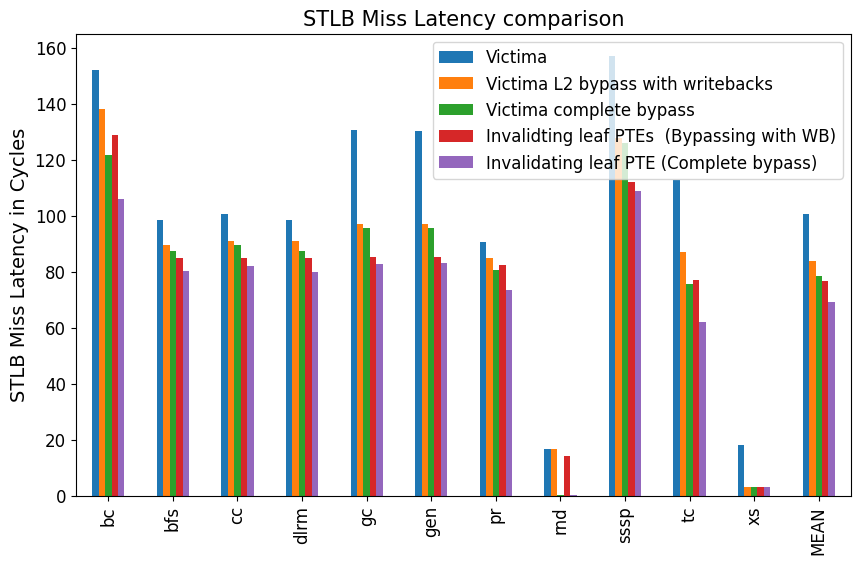

In [8]:


ptw_lats = []
for df in data_dfs:
    ptw_lats.append(get_stlb_miss_penalties_df(df))

# print(ptw_lats[0])

cmp = compare(ptw_lats, headings)

# print(cmp)

cmp.plot(kind='bar', figsize=(10, 6))
plt.ylabel('STLB Miss Latency in Cycles')
plt.title('STLB Miss Latency comparison')
plt.show()


## Average PTW latency

In [9]:
def get_avg_ptw_latency(df):
    label = 'Average PTW Latency'
    # Initialize an empty DataFrame with 'STLB Miss Penalty' as the index
    avg_ptw_lat = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        # Compute the STLB miss penalty
        penalty = convert_to_cycles((df[wl]['ptw_radix_0.page_level_latency_0'] + df[wl]['ptw_radix_0.page_level_latency_1'] 
                                     + df[wl]['ptw_radix_0.page_level_latency_2'] + df[wl]['ptw_radix_0.page_level_latency_3'] 
                                     + df[wl]['ptw_radix_0.page_level_latency_4']) / df[wl]['PTW_0.page_walks'])
        avg_ptw_lat.at[label, wl] = round(penalty, 2)

    return avg_ptw_lat.T


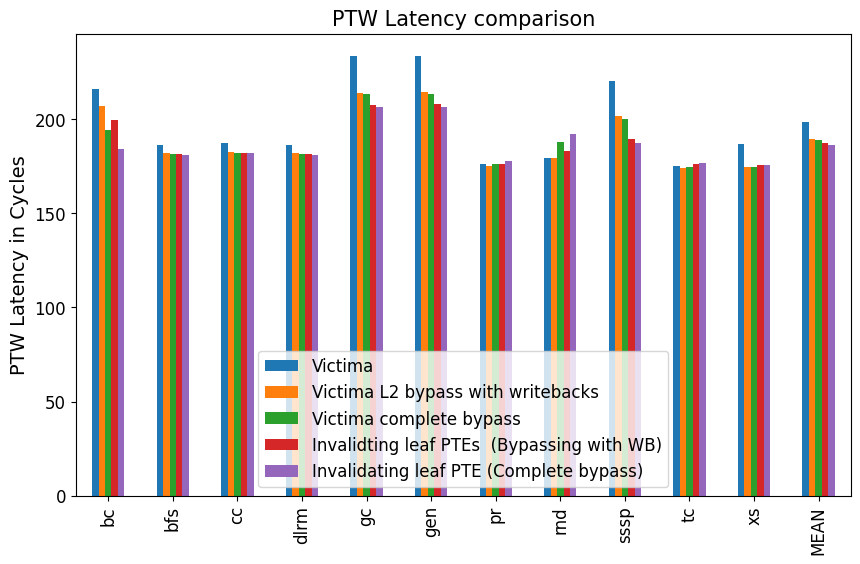

In [10]:


ptw_lats = []
for df in data_dfs:
    ptw_lats.append(get_avg_ptw_latency(df))

cmp = compare(ptw_lats, headings)

# print(cmp)

cmp.plot(kind='bar', figsize=(10, 6))
plt.ylabel('PTW Latency in Cycles')
plt.title('PTW Latency comparison')
plt.show()


## Get Cache MPKI

In [11]:
MISSES_TLB_BLOCKS = 'load-misses-tlb_entry'
MISSES_DATA_BLOCKS = 'load-misses-non_page_table'
MISSES_PTE_BLOCKS = 'load-misses-page_table'

DATA_BLOCK = 'Data'
PTE_BLOCK = 'PTE'
TLB_BLOCK = 'TLB'


block_type = {
    MISSES_TLB_BLOCKS: TLB_BLOCK,
    MISSES_DATA_BLOCKS: DATA_BLOCK,
    MISSES_PTE_BLOCKS: PTE_BLOCK,
}



# Now return a df as done in the previous function
def get_cache_mpki(df, cache_name, misses_name):
    # label = f'{cache_name} {block_type[misses_name]} MPKI'
    label = 'MPKI'

    mpki = pd.DataFrame(index=[label], columns=workloads)
    attr = cache_name + '.' + misses_name

    for wl in workloads:
        mpki.at[label, wl] = round(df[wl][attr] / df[wl]['core.instructions'] * 1000, 2)

    return mpki.T



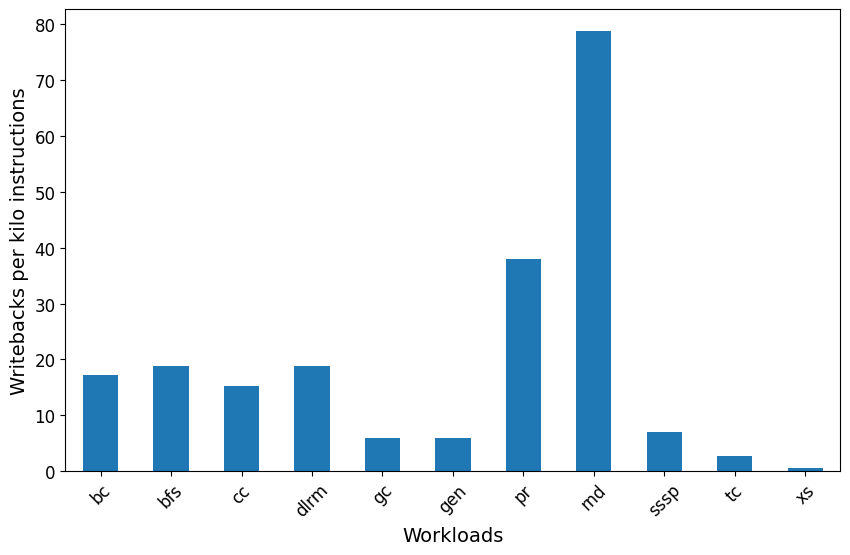

In [12]:
# compare([get_cache_mpki(data_dfs[i], 'L2', MISSES_TLB_BLOCKS) for i in range(len(data_dfs))], headings)
# compare([get_cache_mpki(data_dfs[i], 'L2', 'evict-M') for i in range(len(data_dfs))], headings)

mpk = get_cache_mpki(data_dfs[0], 'L1-D', 'evict-M')


mpk.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Writebacks per kilo instructions')
# plt.title('L1-D Writebacks comparison')
# rotate x labels
plt.xlabel('Workloads')

# hide the legend
plt.legend().set_visible(False)

plt.xticks(rotation=45)
plt.show()



        Victima Victima L2 bypass with writebacks Victima complete bypass  \
bc         7.23                              6.84                    6.37   
bfs       34.37                              31.9                   31.19   
cc        42.09                             38.92                   38.27   
dlrm      34.38                             31.95                   31.25   
gc        32.88                             26.57                   26.21   
gen       32.88                             26.55                   26.22   
pr        17.92                             16.86                   15.94   
rnd        5.95                              5.94                    0.03   
sssp      43.28                             38.18                   37.85   
tc         3.95                              3.06                    2.65   
xs         1.29                              0.24                    0.24   
MEAN  23.292727                         20.637273               19.656364   

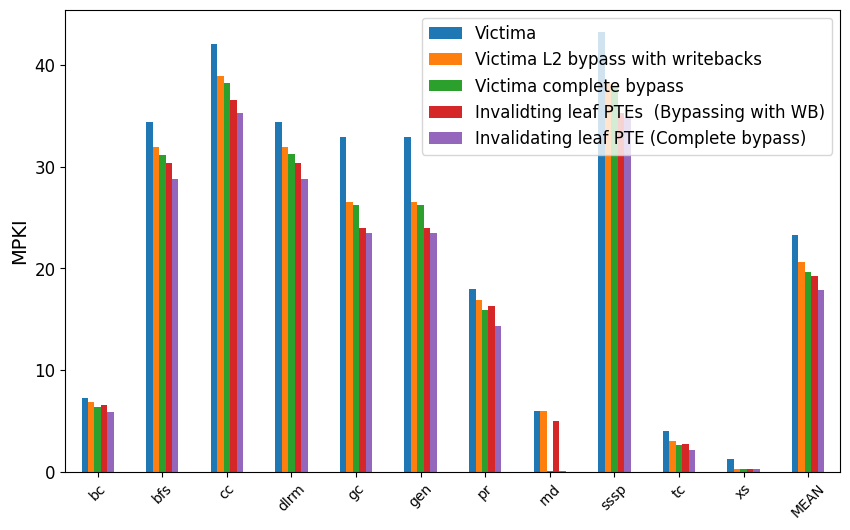

In [13]:
# Plot the comparison of different types of MPKI for different configurations

def plot_MPKI_comparison(cache_name, miss_type, get_mpki_func=get_cache_mpki):
    mpkis = []
    for df in data_dfs:
        mpkis.append(get_mpki_func(df, cache_name, miss_type))

    cmp = compare(mpkis, headings)

    print(cmp)

    cmp.plot(kind='bar', figsize=(10, 6))
    plt.ylabel('MPKI')
    plt.xticks(rotation=45, fontsize=10)
    # plt.title(f'{miss_type} MPKI comparison')
    plt.show()


# plot_MPKI_comparison('L2', MISSES_DATA_BLOCKS)
plot_MPKI_comparison('L2', MISSES_TLB_BLOCKS)
# plot_MPKI_comparison('L2', MISSES_PTE_BLOCKS)


# plot_MPKI_comparison('L1-D', 'evict-M')
# plot_MPKI_comparison('L2', 'evict-M')



## NUCA Cache analysis

     Victima Victima L2 bypass with writebacks Victima complete bypass  \
bc      9.49                              8.52                    7.24   
bfs    35.79                             32.29                   31.36   
cc     43.87                             39.29                   38.43   
dlrm    35.8                             32.36                   31.42   
gc     43.43                             31.27                   30.66   
gen    43.44                             31.28                   30.67   
pr      17.8                             16.66                   15.66   
rnd     5.75                              5.74                    0.03   
sssp   57.96                             45.67                   44.84   
tc      3.88                               3.0                    2.59   
xs      1.44                              0.24                    0.24   
MEAN   27.15                         22.392727               21.194545   

     Invalidting leaf PTEs  (Bypassin

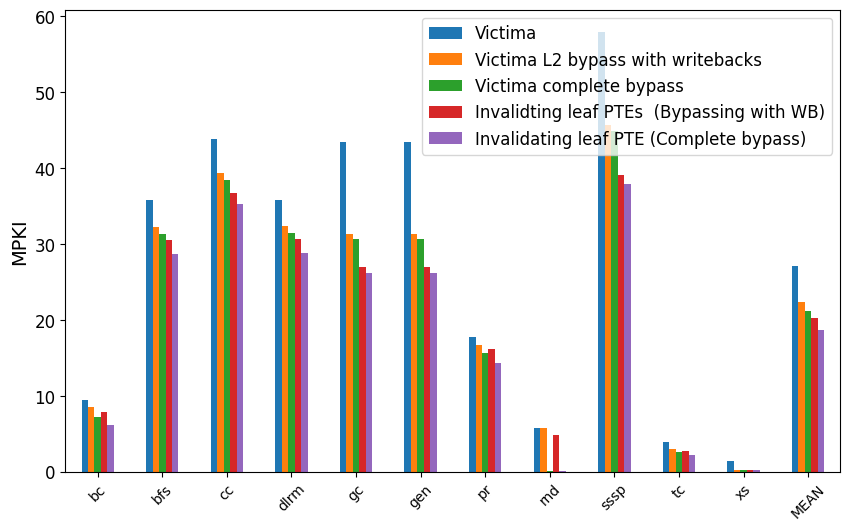

        Victima Victima L2 bypass with writebacks Victima complete bypass  \
bc        16.33                               0.0                     0.0   
bfs       15.85                               0.0                     0.0   
cc        12.73                               0.0                     0.0   
dlrm      15.84                               0.0                     0.0   
gc         4.84                               0.0                     0.0   
gen        4.84                               0.0                     0.0   
pr        37.51                               0.0                     0.0   
rnd       75.98                               0.0                     0.0   
sssp       6.07                               0.0                     0.0   
tc         2.71                               0.0                     0.0   
xs          0.0                               0.0                     0.0   
MEAN  17.518182                               0.0                     0.0   

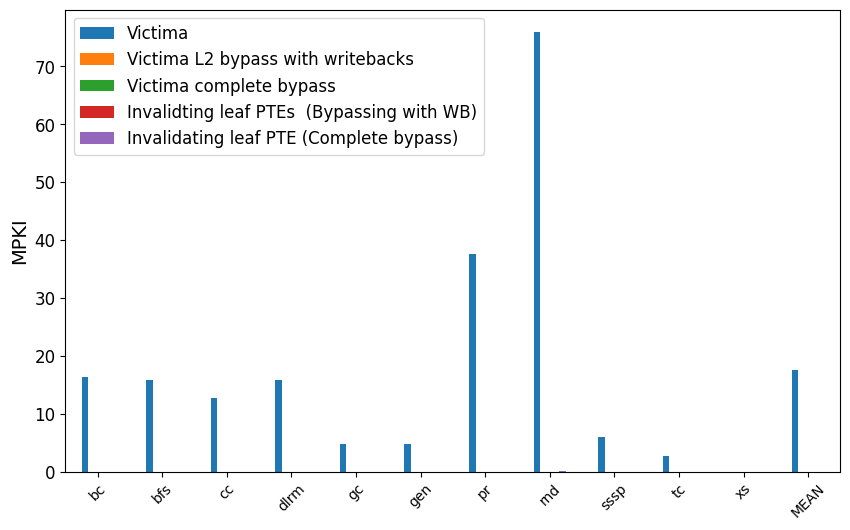

In [14]:
MISSES_READ_NUCA = 'read-misses'
MISSES_WRITE_NUCA = 'write-misses'


def get_llc_mpki(df, cache_name, misses_name):
    label = f'LLC {misses_name} MPKI'

    mpki = pd.DataFrame(index=[label], columns=workloads)
    attr = cache_name + '.' + misses_name

    for wl in workloads:
        mpki.at[label, wl] = round(df[wl][attr] / df[wl]['core.instructions'] * 1000, 2)

    return mpki.T

plot_MPKI_comparison('nuca-cache', MISSES_READ_NUCA, get_llc_mpki)
plot_MPKI_comparison('nuca-cache', MISSES_WRITE_NUCA, get_llc_mpki)






## The REUSE values!
Note that the reuse is recorded after the blocks are evicted!

In [15]:
import pandas as pd

DATA_REUSE = 'data'
PTE_REUSE = 'metadata'
TLB_REUSE = 'tlb'

def get_reuse_attrs(cache_name, type):
    return [f'{cache_name}.{type}-reuse-{i}' for i in range(5)]

def get_cache_reuse(df, cache_name, type):
    attrs = get_reuse_attrs(cache_name, type)

    # Initialize DataFrame properly with attributes as rows and workloads as columns
    reuse = pd.DataFrame(index=attrs, columns=workloads)

    for wl in workloads:
        for attr in attrs:
            reuse.at[attr, wl] = df[wl][attr]  # Assign values correctly

    reuse = reuse.T

    # now calculate the percentage of each reuse level
    for wl in workloads:
        total = reuse.loc[wl].sum()
        for attr in attrs:
            reuse.at[wl, attr] = round(reuse.at[wl, attr] / total * 100, 2)

    # add a row for mean values
    reuse.loc['mean'] = reuse.mean()

    return reuse  # Transpose to maintain workload as rows


def plot_reuse(df_inp, cache_name, type, heading):
    d1 = get_cache_reuse(df_inp, cache_name, type)

    # Define custom colors
    # colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green
    # define 5 levels of colors for each reuse level starting from gray and going to green
    # colors = ["#808080", "#6666bb", "#C0C0C0", "#D3D3D3", "#77bb77"]

    #rename the columns
    d1.columns = ['Reuse 0', 'Reuse 1-5', 'Reuse 6-10', 'Reuse 11-20', 'Reuse >20']


    # Plot stacked bar chart
    ax = d1.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab10")
    # ax = d1.plot(kind="bar", stacked=True, figsize=(12, 6), color=colors)

    # Labels and title
    plt.ylabel("Percentage")
    plt.xlabel("Workload")
    # plt.title(heading)

    #rotate x labels
    plt.xticks(rotation=45)


    # Add legend outside
    plt.legend(title="Reuse Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    # set y limit to 100
    plt.ylim(0, 100)

    # Show plot
    plt.tight_layout()
    plt.show()


### Data Blocks reuse in L2

In [16]:
# print("Data Reuse")
# for i in range(len(data_dfs)):
#     plot_reuse(data_dfs[i], 'L2', DATA_REUSE, headings[i])



### PTE Blocks reuse in L2

PTE Reuse


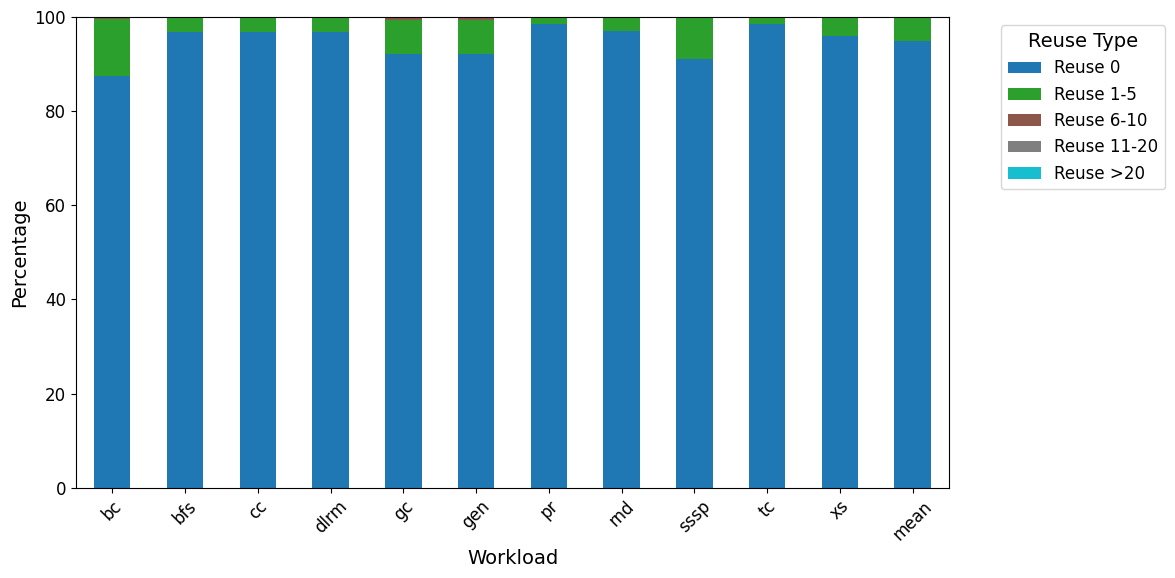

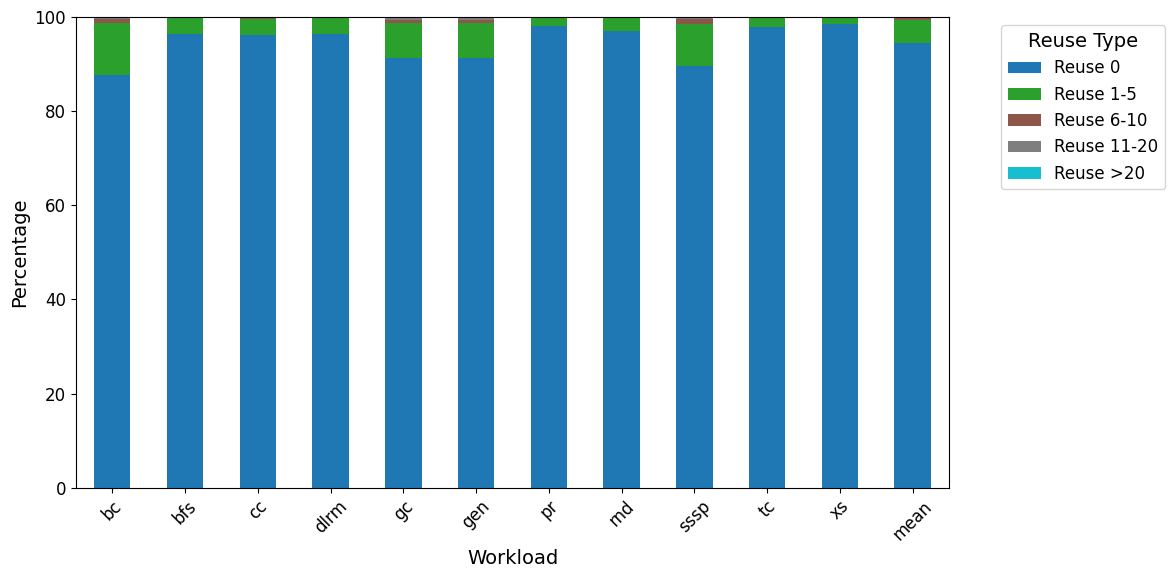

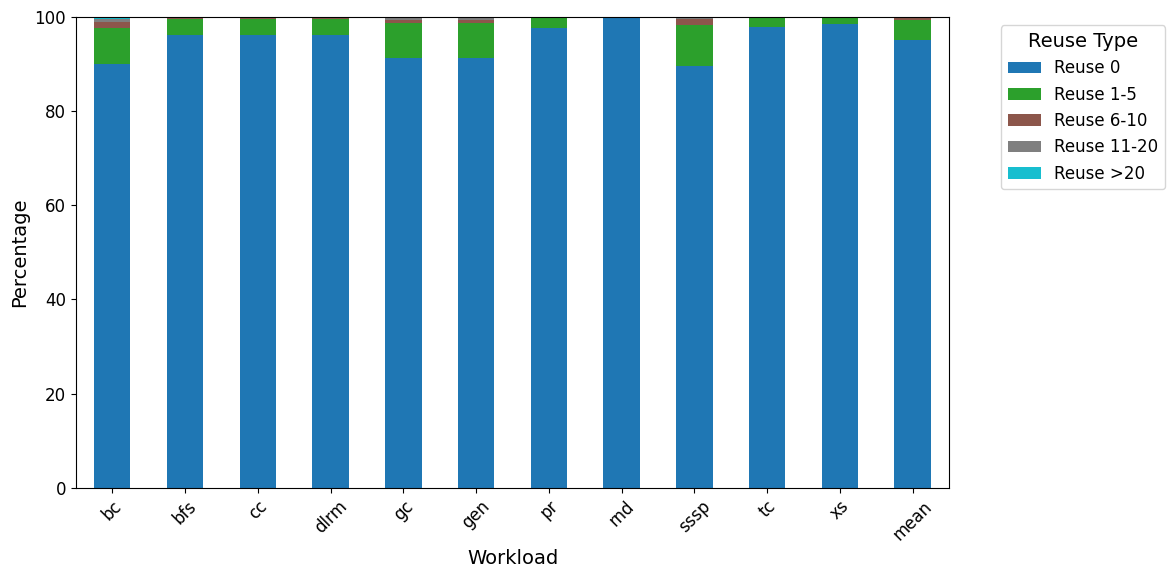

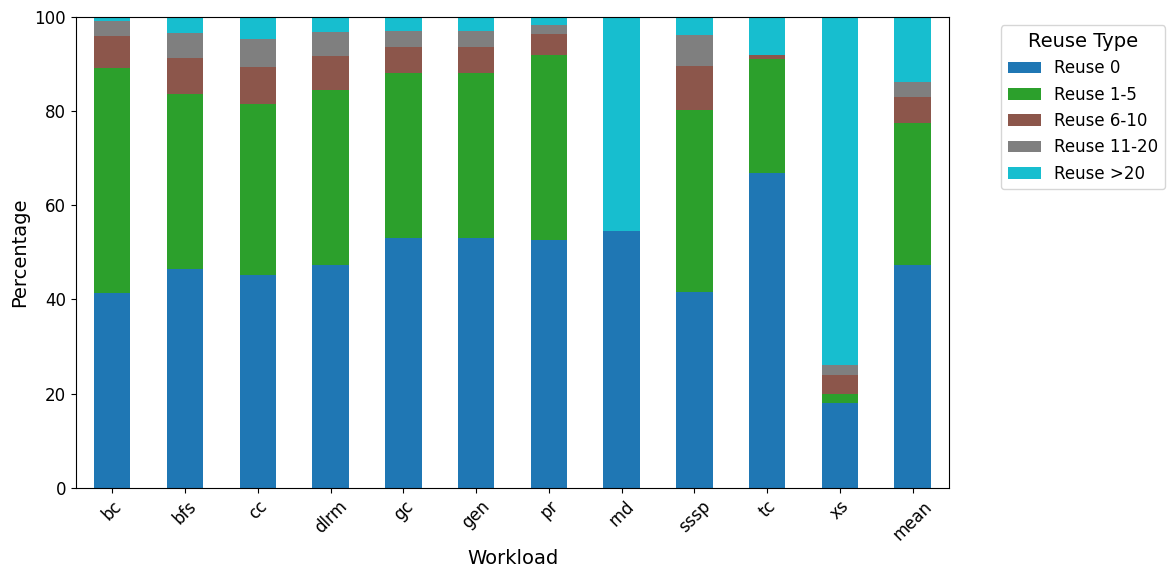

/tmp/ipykernel_996746/663942373.py:26: RuntimeWarning: invalid value encountered in scalar divide
  reuse.at[wl, attr] = round(reuse.at[wl, attr] / total * 100, 2)


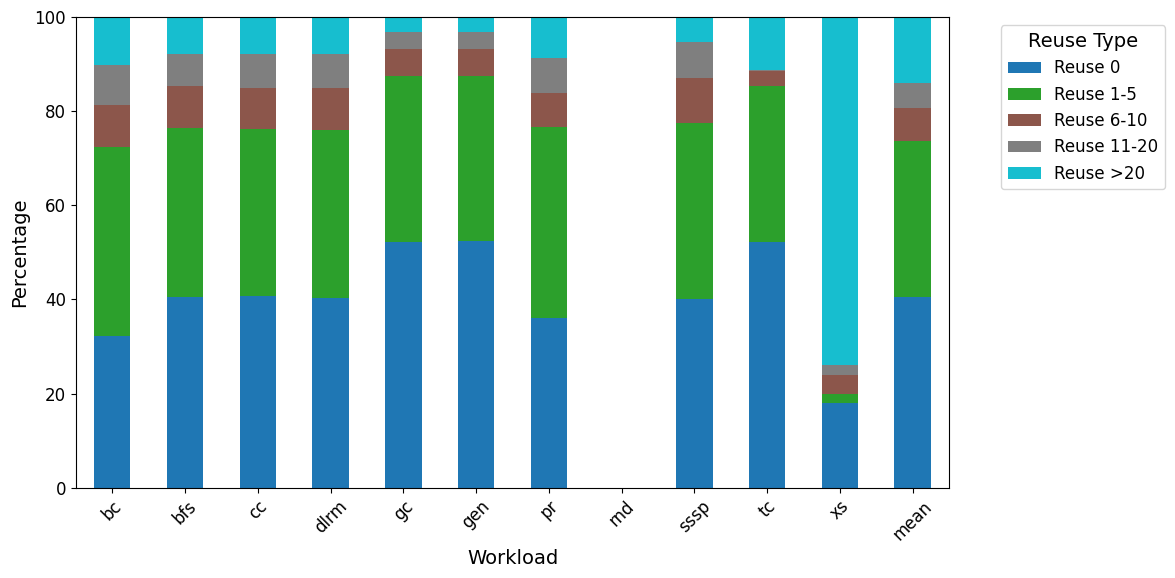

In [17]:
print("PTE Reuse")
for i in range(len(data_dfs)):
    plot_reuse(data_dfs[i], 'L2', PTE_REUSE, headings[i])

### TLB Blocks Reuse in L2

In [18]:
# print("TLB Reuse")
# for i in range(len(data_dfs)):
#     plot_reuse(data_dfs[i], 'L2', TLB_REUSE, headings[i])

## Get the IPC

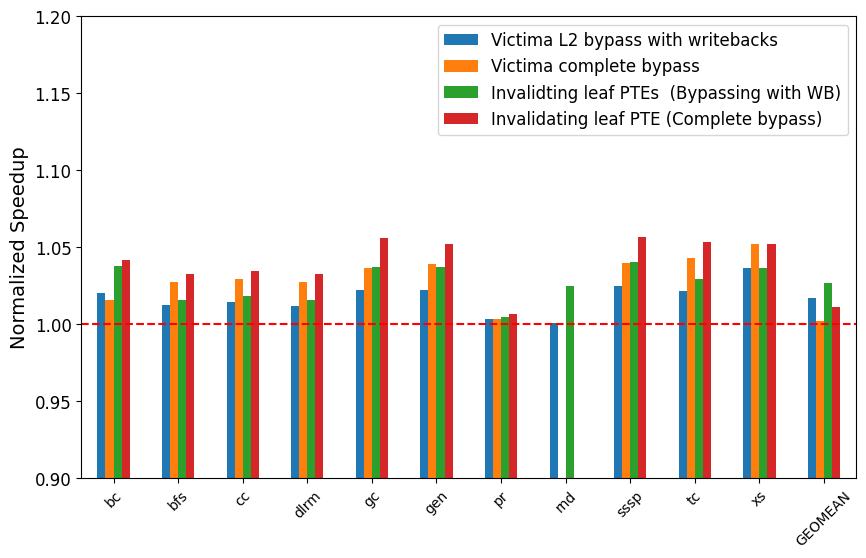

In [19]:
def get_ipc(df):
    label = 'IPC'
    ipc = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        ipc.at[label, wl] = df[wl]['ipc']

    return ipc.T

def get_normalized_speedup(df_base, df_cmp, hardcode_rnd=False):
    label = 'Normalized Speedup'
    speedup = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        # hardcode speedup for rnd to 1.3164
        if wl == 'rnd' and hardcode_rnd:
            speedup.at[label, wl] = 1.3164
        else:
            speedup.at[label, wl] = df_cmp[wl]['ipc'] / df_base[wl]['ipc']

    return speedup.T


# print(get_ipc(data_dfs[3]))

imps = []
for i in range(1, len(data_dfs)):
    imps.append(get_normalized_speedup(data_dfs[0], data_dfs[i]))


cmp = compare(imps, headings[1:], 'geomean')


#plot the speedups
cmp.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Normalized Speedup')
# plt.title('Normalized Speedup over baseline victima')

# set y min and max
plt.ylim(0.9, 1.2)

# increase the font size of the x labels
plt.xticks(fontsize=10, rotation=45)

# highlight y = 1 on the plot
plt.axhline(y=1, color='r', linestyle='--')

plt.show()

In [20]:
cmp.to_excel('speedups.xlsx')

## DRAM related analysis

### DRAM Traffic Analysis

In [21]:
# Analyze the dram.reads and dram.writes
def get_dram_traffic(df):
    label = 'DRAM Traffic'
    dram_traffic = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        dram_traffic.at[label, wl] = df[wl]['dram.reads'] + df[wl]['dram.writes']

    return dram_traffic


def get_dram_reads(df):
    label = 'DRAM Reads'
    dram_reads = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        dram_reads.at[label, wl] = df[wl]['dram.reads']

    return dram_reads


def get_dram_writes(df):
    label = 'DRAM Writes'
    dram_writes = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        dram_writes.at[label, wl] = df[wl]['dram.writes']

    return dram_writes


def get_dram_writes_pki(df):
    label = 'DRAM Writes PKI'
    dram_writes_pki = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        dram_writes_pki.at[label, wl] = (df[wl]['dram.writes'] / df[wl]['core.instructions']) * 1000

    return dram_writes_pki.T

In [22]:
def normalize(df_base, df_cmp, attr, title="Comparison"):
    label = title
    comparison = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        comparison.at[label, wl] = df_cmp[wl][attr] / df_base[wl][attr]

    return comparison.T


drts = [] 
drrs = [] 
drws = []
drwpki = []
for df in data_dfs:
    drts.append(get_dram_traffic(df))
    drrs.append(get_dram_reads(df))
    drws.append(get_dram_writes(df))
    drwpki.append(get_dram_writes_pki(df))



In [23]:
def compare_dram(dram_data, label):
    cmps = []
    for i in range(1, len(dram_data)):
        cmps.append(normalize(dram_data[0], dram_data[i], label, headings[i]))

    cmp = compare(cmps, headings[1:], 'none')
    print(cmp)

    cmp.plot(kind='bar', figsize=(10, 6))
    plt.ylabel('Normalized ' + label)
    plt.title(f'Normalized {label} over baseline victima')
    # plt.ylim(1,3)

    plt.show()



# compare_dram(drws, 'DRAM Writes')
# compare_dram(drts, 'DRAM Traffic')

# print(drwpki[0])

compare(drwpki, headings)




,Victima,Victima L2 bypass with writebacks,Victima complete bypass,Invalidting leaf PTEs (Bypassing with WB),Invalidating leaf PTE (Complete bypass)
bc,0.017646,0.002558,25.246852,0.001294,25.360716
bfs,0.036058,0.013828,17.464548,0.003832,17.50412
cc,0.00996,0.014874,13.696174,0.00463,13.720178
dlrm,0.038354,0.013646,17.46229,0.003666,17.502072
gc,0.063202,0.000754,5.995046,0.001954,4.905476
gen,0.063086,0.000744,4.905518,0.0019,5.999588
pr,0.015392,0.000038,48.780296,0.00002,48.853436
rnd,0.03245,0.028344,151.761584,0.021272,151.762922
sssp,0.010012,0.00054,6.805234,0.001782,6.811944
tc,0.002836,0.000022,3.003032,0.000032,3.014114


### DRAM Latency Analysis

In [24]:
def get_dram_latency(df):
    label = 'DRAM Access Letency'
    dram_lat = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        dram_lat.at[label, wl] = df[wl]['dram.total-access-latency']/(df[wl]['dram.reads'] + df[wl]['dram.writes'])
        dram_lat.at[label, wl] = convert_to_cycles(dram_lat.at[label, wl])

    return dram_lat.T

         Victima Victima L2 bypass with writebacks Victima complete bypass  \
bc    137.771916                               0.0                     0.0   
bfs   139.796076                               0.0                     0.0   
cc    140.535341                               0.0                     0.0   
dlrm  139.794153                               0.0                     0.0   
gc    140.196322                               0.0                     0.0   
gen   140.199679                               0.0                     0.0   
pr    132.113019                               0.0                     0.0   
rnd   151.497119                               0.0               178.13392   
sssp  137.962634                               0.0                     0.0   
tc    138.525414                               0.0                     0.0   
xs    140.191464                               0.0                     0.0   
MEAN  139.871194                               0.0              

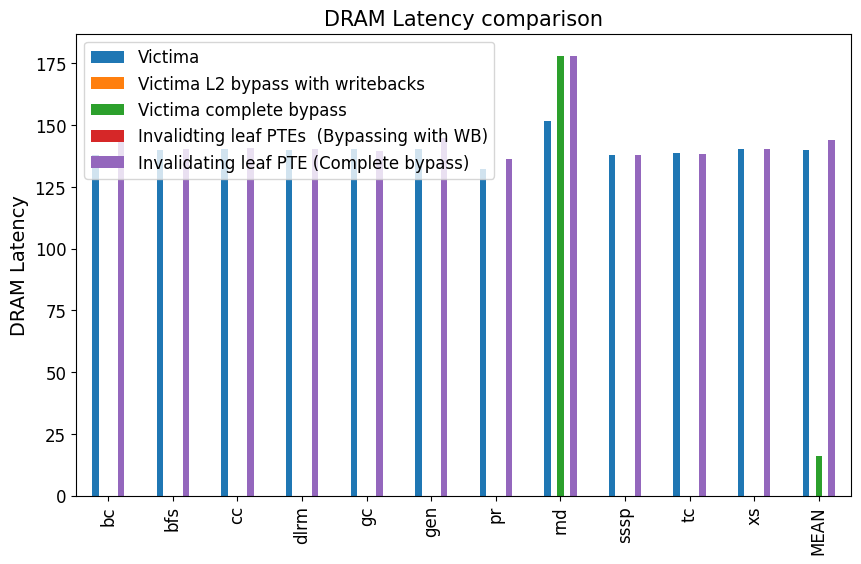

In [25]:
# Compare and plot the DRAM latency
drls = []
for df in data_dfs:
    drls.append(get_dram_latency(df))

# print(drls[0])

cmp = compare(drls, headings, 'mean')
print(cmp)

cmp.plot(kind='bar', figsize=(10, 6))
plt.ylabel('DRAM Latency')
plt.title('DRAM Latency comparison')
plt.show()

## Get Miss Latency

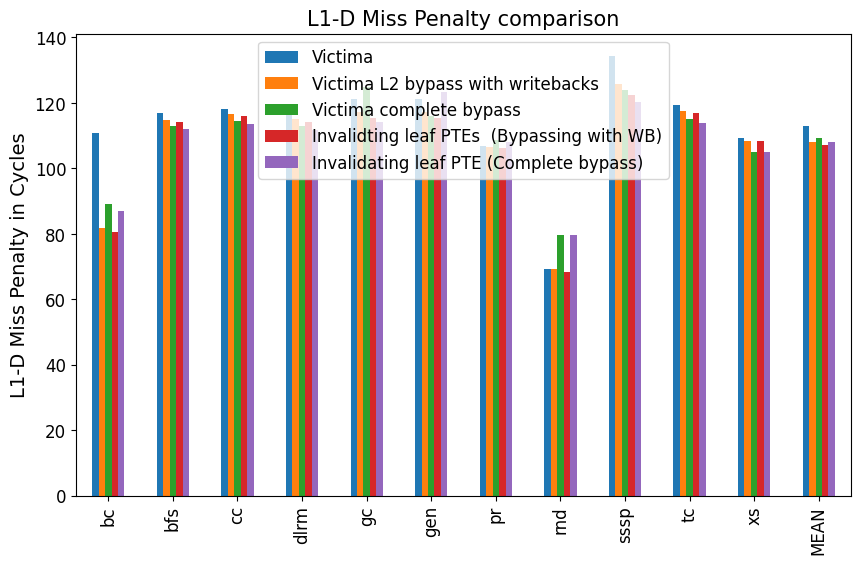

In [26]:
# Now return a df as done in the previous function
def get_cache_miss_penalty(df, cache_name):
    label = f'{cache_name} Miss Penalty'
    mpki = pd.DataFrame(index=[label], columns=workloads)
    load_misses_attr = cache_name + '.tload-misses'
    store_misses_attr = cache_name + '.tstore-misses'
    tot_latency_attr = cache_name + '.total-latency'


    for wl in workloads:
        mpki.at[label, wl] = round(df[wl][tot_latency_attr] / (df[wl][load_misses_attr] + df[wl][store_misses_attr]), 2)
        mpki.at[label, wl] = convert_to_cycles(mpki.at[label, wl])

    return mpki.T


d = [get_cache_miss_penalty(di, 'L1-D') for di, li in zip(data_dfs, headings)]
cmp = compare(d, headings)

cmp.plot(kind='bar', figsize=(10, 6))
plt.ylabel('L1-D Miss Penalty in Cycles')
plt.title('L1-D Miss Penalty comparison')
plt.show()


## Occupancy

          Data Blocks  PTE Blocks  TLB Blocks
workload                                     
bc          50.419080   26.807019   22.773901
bfs         59.164075   16.873047   23.962878
cc          58.470813   17.261401   24.267786
dlrm        59.171460   16.858997   23.969543
gc          55.479956   22.098352   22.421692
gen         55.474365   22.098840   22.426794
pr          66.009851   13.956152   20.033997
rnd         52.385937    4.205591   43.408472
sssp        53.945349   23.969556   22.085095
tc          64.054712   14.264453   21.680835
xs          72.375183    3.275134   24.349683
MEAN        58.813707   16.515322   24.670971


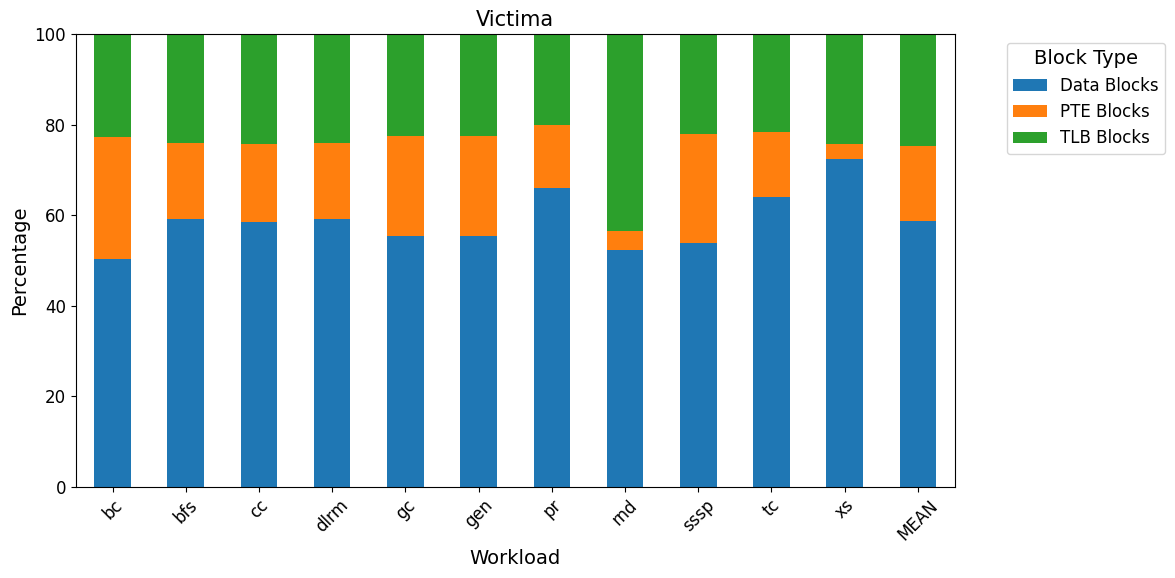

          Data Blocks  PTE Blocks  TLB Blocks
workload                                     
bc          32.446619   36.102185   31.451196
bfs         11.562708   36.732117   51.705176
cc           7.164258   38.535632   54.300110
dlrm        11.583447   36.795251   51.621301
gc           5.405139   44.541675   50.053186
gen          5.410437   44.508765   50.080798
pr          31.373279   27.941602   40.685120
rnd         52.381116    4.210327   43.408557
sssp         2.621899   49.386902   47.991199
tc          22.772986   27.141199   50.085815
xs           0.048828   33.845459   66.105713
MEAN        16.615520   34.521919   48.862561


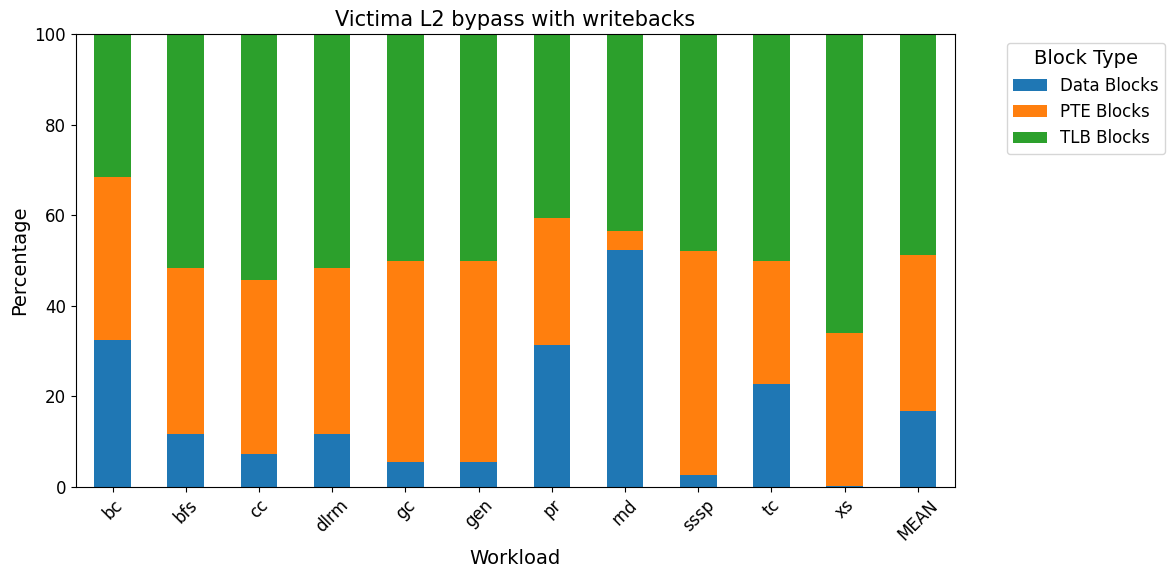

          Data Blocks  PTE Blocks  TLB Blocks
workload                                     
bc           0.000000   52.287646   47.712354
bfs          0.000000   41.223096   58.776904
cc           0.000000   41.280249   58.719751
dlrm         0.000000   41.209607   58.790393
gc           0.000513   46.850098   53.149390
gen          0.000525   46.852258   53.147217
pr           0.000000   39.389587   60.610413
rnd          0.016875   47.662763   52.320362
sssp         0.000000   50.665552   49.334448
tc           0.000000   32.956616   67.043384
xs           0.000000   33.880737   66.119263
MEAN         0.001628   43.114383   56.883989


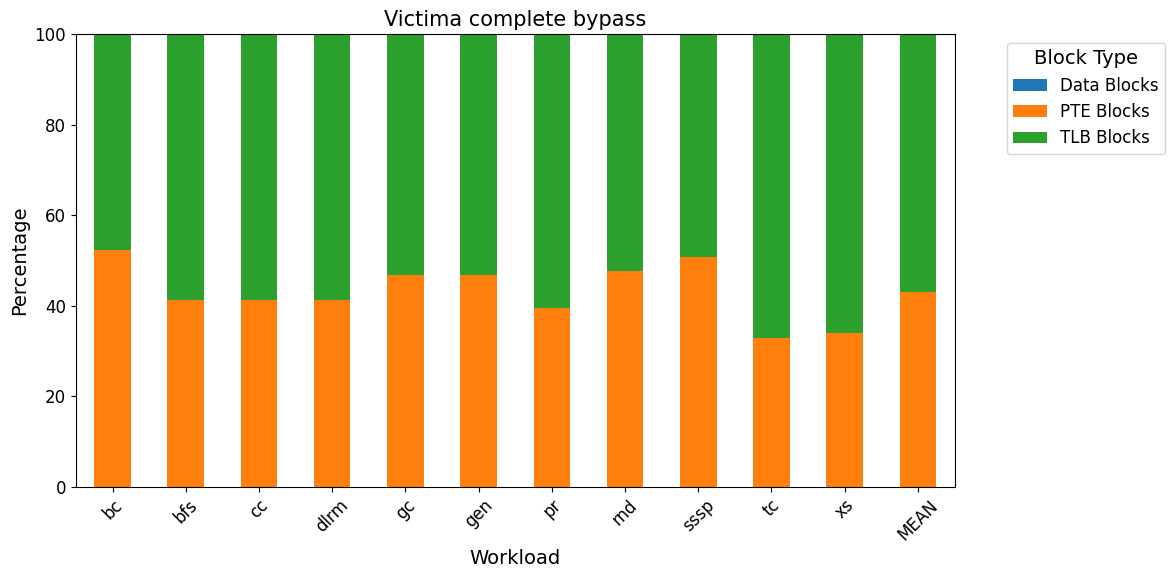

          Data Blocks  PTE Blocks  TLB Blocks
workload                                     
bc          42.373919   17.665749   39.960331
bfs         17.447122    5.573329   76.979549
cc          11.094905    5.736767   83.168328
dlrm        17.439625    5.526064   77.034311
gc           7.600657   19.985677   72.413665
gen          7.603796   19.985578   72.410626
pr          42.890236    2.079140   55.030624
rnd         55.583493    0.199074   44.217433
sssp         4.091392   23.529183   72.379425
tc          31.526561    1.909610   66.563829
xs           0.050398    2.877082   97.072520
MEAN        21.609282    9.551568   68.839149


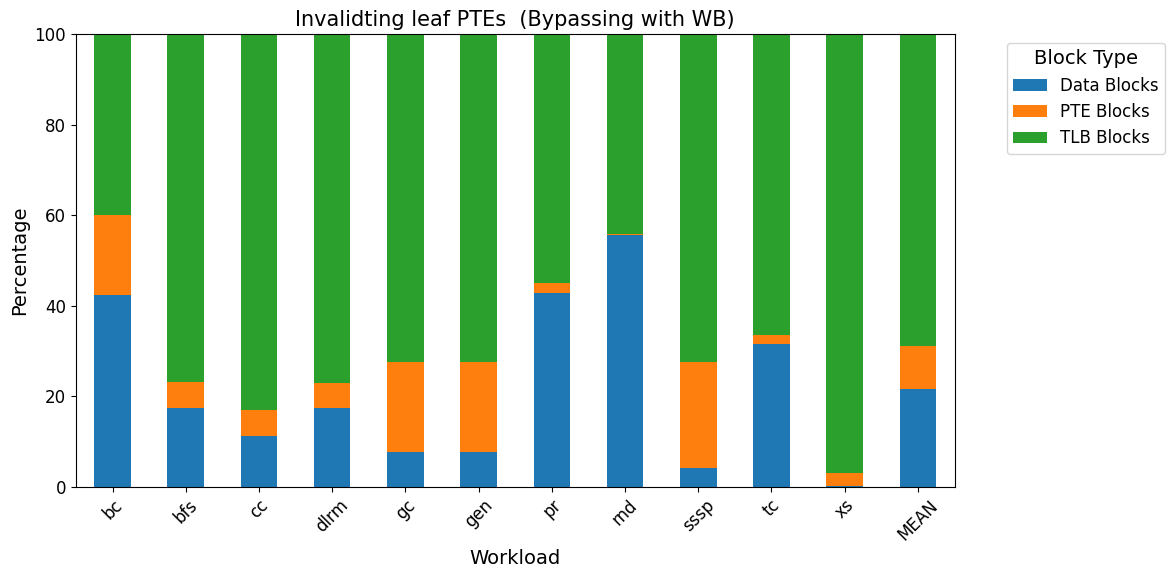

          Data Blocks  PTE Blocks  TLB Blocks
workload                                     
bc           0.000000   24.490552   75.509448
bfs          0.000000    5.956456   94.043544
cc           0.000000    5.947191   94.052809
dlrm         0.000000    5.982699   94.017301
gc           0.000553   21.068540   78.930907
gen          0.000566   21.035849   78.963585
pr           0.000000    2.291027   97.708973
rnd          0.057759    0.455654   99.486587
sssp         0.000000   24.098576   75.901424
tc           0.000000    1.952020   98.047980
xs           0.000000    2.870711   97.129289
MEAN         0.005353   10.559025   89.435623


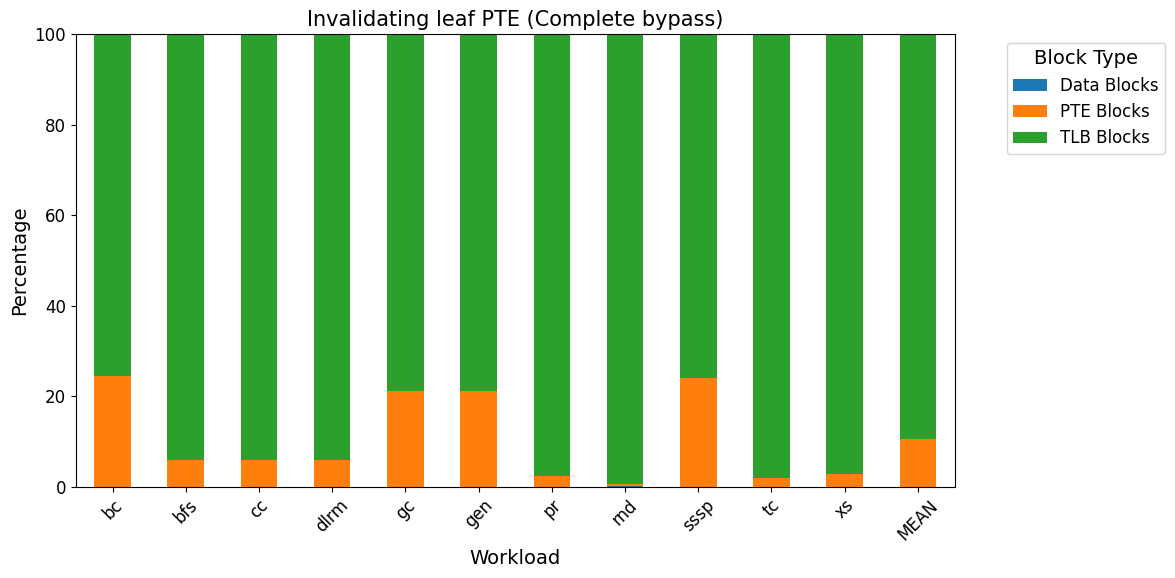

In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_avg_occupancy(folder_path, heading):
    # Initialize list to store final dataframe data
    final_data = []

    # Process each .out file in the folder
    for file in os.listdir(folder_path):
        if file.endswith(".out"):
            trace_name = file.replace(".out", "")
            file_path = os.path.join(folder_path, file)
            
            # Read the .out file and extract relevant data
            data = []
            with open(file_path, "r") as f:
                for line in f:
                    if "Occupancy in L2:" in line:
                        parts = line.strip().split(": ")[1].split(", ")
                        data.append([int(parts[0]), int(parts[1]), int(parts[2])])
            
            # Create a dataframe for the trace
            df = pd.DataFrame(data, columns=["num_data_blocks", "num_pte_blocks", "num_tlb_blocks"])
            
            # Compute average occupancy values for the bottom half
            bottom_half = df.iloc[len(df)//2:]
            total_blocks = bottom_half.sum(axis=1)
            avg_data_occupancy = ((bottom_half["num_data_blocks"] / total_blocks) * 100).mean()
            avg_pte_occupancy = ((bottom_half["num_pte_blocks"] / total_blocks) * 100).mean()
            avg_tlb_occupancy = ((bottom_half["num_tlb_blocks"] / total_blocks) * 100).mean()
            
            # Store the results for the final dataframe
            final_data.append([trace_name, avg_data_occupancy, avg_pte_occupancy, avg_tlb_occupancy])


    # Create final dataframe
    final_df = pd.DataFrame(final_data, columns=["workload", "Data Blocks", "PTE Blocks", "TLB Blocks"])

    # set index to workload
    final_df.set_index("workload", inplace=True)

    # bars except the MEAN row should be sorted by alphabetical order
    final_df = final_df.sort_index()

    # Add mean values for each block type
    final_df.loc['MEAN'] = final_df.mean()

    # Define custom colors
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green

    # Plot a stacked bar chart with Y limit to 100
    ax = final_df.plot(kind="bar", stacked=True, figsize=(12, 6), color=colors)
    
    print(final_df)

    plt.ylabel("Percentage")
    plt.xlabel("Workload")
    plt.title(heading)
    plt.legend(title="Block Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Run the function for each path
for i in range(0, len(paths)):
    plot_avg_occupancy(paths[i], headings[i])
